In [1]:
import argparse
import csv
import datetime
import pickle
from concurrent import futures

import numpy as np
import pandas as pd
import pytz
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


In [11]:
import datetime

import numpy as np
import pandas as pd
import pytz



def interpolate_arr(new_times, new_vals):
    new_times_inter = []
    new_vals_inter = []
    last_val = None
    last_time = None
    for t_idx in range(len(new_times)):
        t = new_times[t_idx]
        v = new_vals[t_idx]

        if last_time is not None:
            # Interpolate any missing values minute-by-minute
            # e.g. if last_time was 10:00, t is 10:03, we need
            # to add the value at 10:00 for 10:01 and 10:02
            while last_time < (t - datetime.timedelta(minutes=1)):
                last_time = last_time + datetime.timedelta(minutes=1)
                new_times_inter.append(last_time)
                new_vals_inter.append(last_val)
        new_times_inter.append(t)
        new_vals_inter.append(v)
        last_time = t
        last_val = v
    return new_times_inter, new_vals_inter


def avg_arr(b, col, avg_over=60, interpolate=False):
    if col == "MAP":
        s_times = b[f"NBPs-time"]
        d_times = b[f"NBPd-time"]
        s_vals = np.array(b[f"NBPs"])
        d_vals = np.array(b[f"NBPd"])

        times = []
        vals = []
        i = 0
        j = 0
        while i < len(s_times) and j < len(d_times):
            if s_times[i] == d_times[j]:
                vals.append((1 / 3) * (s_vals[i] + d_vals[j] * 2))
                times.append(s_times[i])
                i += 1
                j += 1
            elif s_times[i] < d_times[j]:
                i += 1
            else:
                j += 1

        # avg_over = None
    else:
        times = b[f"{col}-time"]
        vals = b[col]

    # if avg_over is None:
    #     if interpolate:
    #         times, vals = interpolate_arr(times, vals)
    #     print(f"col={col} len {len(times)}")
    #     return np.array(times), np.array(vals)

    # Go through window by window
    new_times = []
    new_vals = []
    window_times = []
    window_vals = []
    for i in range(len(times)):
        if avg_over is None:
            new_times.append(times[i])
            new_vals.append(vals[i])
        elif len(window_vals) == 0:
            window_times.append(times[i])
            window_vals.append(vals[i])
        elif (times[i] - window_times[0]).total_seconds() >= avg_over:
            new_times.append(window_times[0])
            new_vals.append(np.mean(window_vals))
            window_times = []
            window_vals = []
        window_times.append(times[i])
        window_vals.append(vals[i])

    # Add any straggling remaining values
    if len(window_times) > 0:
        new_times.append(window_times[0])
        new_vals.append(np.mean(window_vals))

    # Interpolate if necessary
    if interpolate:
        new_times, new_vals = interpolate_arr(new_times, new_vals)

    return np.array(new_times), np.array(new_vals)


def coverage_fraction_step(waveform_times, waveform_vals, nurse_times, nurse_vals, bound):
    if len(waveform_times) <= 0 or len(nurse_times) <= 0:
        return None, None

    covered_arr = []  # bit array of 1 = covered, 0 = not covered
    y_pred = []  # the latest nurse chart repeated

    covered_count = 0
    total_count = 0

    # Skip any waveform times that come before the first nurse time
    j = 0
    while j < len(waveform_times) and nurse_times[0] > waveform_times[j]:
        covered_arr.append(float("nan"))
        y_pred.append(float("nan"))
        total_count += 1
        j += 1

    while j < len(waveform_times):
        # Get most recent nurse measure
        curr_nurse_vals = nurse_vals[nurse_times <= waveform_times[j]]
        if len(curr_nurse_vals) == 0:
            # Waveform time is before earliest nurse time so we punish algorithm
            covered_arr.append(0)
            y_pred.append(float("nan"))
        else:
            next_nurse_val = curr_nurse_vals[-1]
            if next_nurse_val - bound <= waveform_vals[j] <= next_nurse_val + bound:
                covered_arr.append(1)
                covered_count += 1
            else:
                covered_arr.append(0)
            y_pred.append(next_nurse_val)
        total_count += 1
        j += 1
    return covered_count, total_count, np.array(covered_arr), np.array(y_pred)


def get_raw_data(csn):
    hash_folder = str(csn)[-2:]

    b = {}
    cols = ["NBPs", "NBPd", "RR", "HR", "SpO2"]
    # cols = ["SpO2"]
    for col in cols:
        df_col = pd.read_csv(f"/deep/group/physiologic-states/v3/csv/{hash_folder}/{csn}/{col}.csv")
        times = df_col["recorded_time"].tolist()
        vals = df_col[col].tolist()

        new_times = []
        new_vals = vals
        for t in times:
            if col == "NBPs" or col == "NBPd":
                try:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S%z")
                except:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f%z")
            else:
                try:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f%z")
                except:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S%z")
            t = t.replace(microsecond=0)
            t = t.replace(second=0)
            new_times.append(t)

        b[f"{col}-time"] = np.array(new_times)
        b[f"{col}"] = np.array(new_vals)
        # print(f"{col}: {len(new_vals)}")

    return b


def get_data(b, df_states, csn, col="HR", avg_over=None, interpolate=False, manual_data_source="nurse",
             manual_sampling_avg_over=None):
    pt_df = df_states[(df_states["CSN"] == csn) & (df_states["Variable"] == col)]

    nurse_times = []
    for x in pt_df["Time"].tolist():
        t = datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        t = pytz.timezone('America/Vancouver').localize(t)
        nurse_times.append(t)
    nurse_vital_signs = pt_df["Charted"].tolist()

    waveform_times, waveform_vital_signs = avg_arr(b, col, avg_over=avg_over, interpolate=interpolate)

    if manual_data_source != "nurse":
        nurse_times, nurse_vital_signs = avg_arr(b, col, avg_over=manual_sampling_avg_over)

    return nurse_times, nurse_vital_signs, waveform_times, waveform_vital_signs





## Calculate All Modality Coverage (Nurse)

In [3]:

pd.set_option('display.max_columns', None)

COLS = ["HR", "RR", "SpO2", "MAP"]
BOUNDS = {
    "HR": 5,
    "RR": 3,
    "SpO2": 2,
    "MAP": 6
}

def avg_arr(b, col, avg_over=60):
    if col == "MAP":
        s_times = b[f"NBPs-time"]
        d_times = b[f"NBPd-time"]
        s_vals = np.array(b[f"NBPs"])
        d_vals = np.array(b[f"NBPd"])

        times = []
        vals = []
        i = 0
        j = 0
        while i < len(s_times) and j < len(d_times):
            if s_times[i] == d_times[j]:
                vals.append((1 / 3) * (s_vals[i] + d_vals[j] * 2))
                times.append(s_times[i])
                i += 1
                j += 1
            elif s_times[i] < d_times[j]:
                i += 1
            else:
                j += 1

        avg_over = None
    else:
        times = b[f"{col}-time"]
        vals = b[col]

    if avg_over is None:
        return np.array(times), np.array(vals)

    new_times = []
    new_vals = []
    window_times = []
    window_vals = []
    for i in range(len(times)):
        if avg_over is None:
            new_times.append(times[i])
            new_vals.append(vals[i])
        elif len(window_vals) == 0:
            window_times.append(times[i])
            window_vals.append(vals[i])
        elif (times[i] - window_times[0]).total_seconds() > avg_over:
            new_times.append(window_times[0])
            new_vals.append(np.mean(window_vals))
            window_times = []
            window_vals = []
        window_times.append(times[i])
        window_vals.append(vals[i])

    if len(window_times) > 0:
        new_times.append(window_times[0])
        new_vals.append(np.mean(window_vals))

    return np.array(new_times), np.array(new_vals)


def coverage_fraction_step(waveform_times, waveform_vals, nurse_times, nurse_vals, bound):
    if len(waveform_times) <= 0 or len(nurse_times) <= 0:
        return None, None

    current_nurse_index = 0
    next_nurse_index = 1
    covered_arr = []  # bit array of 1 = covered, 0 = not covered
    y_pred = []  # the latest nurse chart repeated

    covered_count = 0
    total_count = 0

    # Skip any waveform times that come before the first nurse time
    j = 0
    while j < len(waveform_times) and nurse_times[0] > waveform_times[j]:
        covered_arr.append(float("nan"))
        y_pred.append(float("nan"))
        total_count += 1
        j += 1

    while j < len(waveform_times):
        curr_nurse_time = nurse_times[current_nurse_index]
        if current_nurse_index + 1 < len(nurse_times):
            next_nurse_time = nurse_times[current_nurse_index + 1]
        else:
            next_nurse_time = None

        # If waveform time is after the next nurse time, then we need to use the next nurse time
        # since it is more recent
        if next_nurse_time is not None and next_nurse_time < waveform_times[j]:
            current_nurse_index += 1
            # We continue to account for cases where multiple nurse times occur before the
            # next waveform measure. This way, we can use the latest next nurse time before
            # the waveform time at index j.
            continue

        if nurse_vals[current_nurse_index] - bound <= waveform_vals[j] <= nurse_vals[current_nurse_index] + bound:
            covered_arr.append(1)
            covered_count += 1
        else:
            covered_arr.append(0)
        y_pred.append(nurse_vals[current_nurse_index])
        total_count += 1
        j += 1
    return covered_count, total_count, np.array(covered_arr), np.array(y_pred)


def get_raw_data(csn):
    # s3://ed-monitor-data/v3/131291536239/131291536239.h5

    hash_folder = str(csn)[-2:]
    
    b = {}
    cols = ["NBPs", "NBPd", "RR", "HR", "SpO2"]
    for col in cols:
        df_col = pd.read_csv(f"/tmp/deep/group/physiologic-states/v3/csv/{hash_folder}/{csn}/{col}.csv")
        times = df_col["recorded_time"].tolist()
        vals = df_col[col].tolist()
        
        new_times = []
        for t in times:
            if col == "NBPs" or col == "NBPd":
                try:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S%z")
                except:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f%z")
            else:
                try:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f%z")
                except:
                    t = datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S%z")
            t = t.replace(microsecond=0)
            t = t.replace(second=0)
            new_times.append(t)

        b[f"{col}-time"] = np.array(new_times)
        b[f"{col}"] = np.array(vals)
    
    return b

def get_data(b, df_states, csn, col="HR", avg_over=None, manual_data_source="nurse", manual_sampling_avg_over=None):
    pt_df = df_states[(df_states["CSN"] == csn) & (df_states["Variable"] == col)]

    nurse_times = []
    for x in pt_df["Time"].tolist():
        t = datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
        t = pytz.timezone('America/Vancouver').localize(t)
        nurse_times.append(t)
    nurse_vital_signs = pt_df["Charted"].tolist()

    waveform_times, waveform_vital_signs = avg_arr(b, col, avg_over=avg_over)

    if manual_data_source != "nurse":
        nurse_times, nurse_vital_signs = avg_arr(b, col, avg_over=manual_sampling_avg_over)

    return nurse_times, nurse_vital_signs, waveform_times, waveform_vital_signs


# Note: coverage defined by three fields:
# (start index, end index) => (simulated nurse measure, num waveform elements during this range, num waveform elements covered)
# (0, 10) => [110, 4, 2] # if there are values in this range
# (0, 10) => [] # if there are no values in this range


def generate_coverage(col_to_data, min_time, max_time):
    start_end_to_coverage = {}
    for col_idx, col in enumerate(COLS):
        bound = BOUNDS[col]
        waveform_times = col_to_data[col]["waveform_times"]
        waveform_vals = col_to_data[col]["waveform_vital_signs"]
        curr_time = min_time
        # has_started = True
        while curr_time <= max_time:
            if curr_time < min(waveform_times):
                # This modality has not started recording yet, so there's no coverage to calculate
                # has_started = False

                num_elements = 0
                num_covered = 0
                start_min = int((curr_time - min_time).total_seconds() / 60.0)
                curr_time_inner = curr_time
                while curr_time_inner <= max_time:
                    end_min = int((curr_time_inner - min_time).total_seconds() / 60.0)
                    num_elements += 1
                    if (start_min, end_min) not in start_end_to_coverage:
                        start_end_to_coverage[(start_min, end_min)] = [[float("nan") for _ in range(len(COLS))], 0, 0]
                    # Punish the algorithm for starting coverage before the waveform exists
                    start_end_to_coverage[(start_min, end_min)][1] += num_elements
                    curr_time_inner = curr_time_inner + datetime.timedelta(seconds=60)
                curr_time = curr_time + datetime.timedelta(seconds=60)
            else:
                # Get the last waveform val before this time
                simulated_nurse_measure = waveform_vals[waveform_times <= curr_time][-1]
                num_elements = 0
                num_covered = 0
                start_min = int((curr_time - min_time).total_seconds() / 60.0)
                curr_time_inner = curr_time
                while curr_time_inner <= max_time:
                    end_min = int((curr_time_inner - min_time).total_seconds() / 60.0)
                    actual_val = waveform_vals[waveform_times <= curr_time_inner][-1]
                    if (simulated_nurse_measure - bound) <= actual_val <= (simulated_nurse_measure + bound):
                        num_covered += 1
                    num_elements += 1
                    if (start_min, end_min) not in start_end_to_coverage:
                        start_end_to_coverage[(start_min, end_min)] = [[float("nan") for _ in range(len(COLS))], 0, 0]
                    start_end_to_coverage[(start_min, end_min)][0][col_idx] = simulated_nurse_measure
                    start_end_to_coverage[(start_min, end_min)][1] += num_elements
                    start_end_to_coverage[(start_min, end_min)][2] += num_covered

                    curr_time_inner = curr_time_inner + datetime.timedelta(seconds=60)
                curr_time = curr_time + datetime.timedelta(seconds=60)
    return start_end_to_coverage


def find_optimal_coverage(orig_num_resources_left, col_to_data, min_time, max_time, silent=False):
    visited = {}

    def get_simulated_nurse_helper(start_end_to_coverage, min_time, start_time, simulated_nurse_vals, num_resources_left):

        start_min = int((start_time - min_time).total_seconds() / 60.0)
        if (start_min, num_resources_left) in visited:
            return visited[(start_min, num_resources_left)]

        if num_resources_left == 0:
            # No more nurse resources, just give the remaining waveform vals to the last known nurse val
            covered = 0
            total = 0
            for col_idx, col in enumerate(COLS):
                bound = BOUNDS[col]
                waveform_times = col_to_data[col]["waveform_times"]
                waveform_vals = col_to_data[col]["waveform_vital_signs"]
                waveform_vals = waveform_vals[waveform_times > start_time]
                for val in waveform_vals:
                    if simulated_nurse_vals[col_idx] != float("nan"):
                        if (simulated_nurse_vals[col_idx] - bound) <= val <= (simulated_nurse_vals[col_idx] + bound):
                            covered += 1
                    total += 1

                if (start_min, num_resources_left) not in visited:
                    visited[(start_min, num_resources_left)] = [[], [], 0, 0]
                visited[(start_min, num_resources_left)][2] += total
                visited[(start_min, num_resources_left)][3] += covered
            return [], [], visited[(start_min, num_resources_left)][2], visited[(start_min, num_resources_left)][3]

        best_coverage = 0
        best_nurse_times = []
        best_nurse_vals = []
        best_total = 0
        best_covered = 0
        best_coverage_params = None
        curr_min = int((start_time - min_time).total_seconds() / 60.0)
        curr_time = start_time
        while curr_time < max_time:
            #         if start_idx == 0:
            #             print(f"Working on ({start_idx}, {i})")
            if (start_min, curr_min) not in start_end_to_coverage:
                curr_time += datetime.timedelta(seconds=60)
                curr_min += 1

            coverage_params = start_end_to_coverage[(start_min, curr_min)]
            simulated_nurse_vals = coverage_params[0]
            total_in_window = coverage_params[1]
            covered_in_window = coverage_params[2]

            # Also consider how the performance is if we just take the current simulated_nurse_val
            # and use no more further nurse resources
            max_min = int((max_time - min_time).total_seconds() / 60.0)
            coverage_params_to_end = start_end_to_coverage[(start_min, max_min)]
            total_in_window_to_end = coverage_params_to_end[1]
            covered_in_window_to_end = coverage_params_to_end[2]

            nt, nv, total_ret, covered_ret = get_simulated_nurse_helper(start_end_to_coverage, min_time, curr_time, simulated_nurse_vals,
                                                                        num_resources_left - 1)

            nt_so_far = [start_time]
            nv_so_far = [simulated_nurse_vals]
            nt_so_far.extend(nt)
            nv_so_far.extend(nv)

            total = total_in_window + total_ret
            covered = covered_in_window + covered_ret
            curr_coverage = covered / total
            if curr_coverage >= best_coverage:
                best_coverage = curr_coverage
                best_nurse_times = nt_so_far
                best_nurse_vals = nv_so_far
                best_total = total
                best_covered = covered
                best_coverage_params = ((start_min, curr_min), coverage_params)

            # Could taking fewer number of resources also work?
            total_to_end = total_in_window_to_end
            covered_to_end = covered_in_window_to_end
            curr_coverage_to_end = covered_to_end / total_to_end
            # Note the equals because we want to prefer fewer resources if possible
            if curr_coverage_to_end >= best_coverage:
                best_coverage = curr_coverage_to_end
                best_nurse_times = [start_time]
                best_nurse_vals = [simulated_nurse_vals]
                best_total = total_in_window_to_end
                best_covered = covered_in_window_to_end
                best_coverage_params = ((start_min, curr_min), coverage_params)

            curr_time += datetime.timedelta(seconds=60)
            curr_min += 1

        visited[(start_min, num_resources_left)] = [best_nurse_times, best_nurse_vals, best_total, best_covered]
        # if num_resources_left == orig_num_resources_left:
        #     print(num_resources_left, best_coverage_params)
        #     print(best_nurse_times)
        return best_nurse_times, best_nurse_vals, best_total, best_covered

    if not silent:
        print(f"Building Coverage Lookup")
    start_end_to_coverage = generate_coverage(col_to_data, min_time, max_time)
    # for k in start_end_to_coverage.keys():
    #     if k[0] <= 1:
    #         print(k, start_end_to_coverage[k])
    if not silent:
        print(f"num_resources_left={orig_num_resources_left}")
        print(f"Simulating Nurse...")
    nurse_times, nurse_vital_signs, best_total, best_covered = get_simulated_nurse_helper(start_end_to_coverage,
                                                                                          min_time=min_time,
                                                                                          start_time=min_time,
                                                                                          simulated_nurse_vals=None,
                                                                                          num_resources_left=orig_num_resources_left)

    coverage = best_covered / best_total
    # if not silent:
    # print("===")
    # print(f"Coverage Fraction = {coverage}")
    # print(f"Covered = {best_covered}")
    # print(f"Total = {best_total}")
    # print(f"len(nurse_times) = {len(nurse_times)}")
    # print(f"nurse_times = {len(nurse_times)}")
    # print(f"nurse_vital_signs = {len(nurse_vital_signs)}")
    # print("===")

    if silent:
        return best_covered, best_total, nurse_times, nurse_vital_signs


def get_local_coverage(waveform_vals, last_nurse_val, bound):
    covered = 0
    total = 0
    i = 0
    while i < len(waveform_vals):
        if (last_nurse_val - bound) <= waveform_vals[i] <= (last_nurse_val + bound):
            covered += 1
        total += 1
        i += 1
    return total, covered


def get_coverage(input):
    i, total_rows, df, csn = input
    print(f"Working on {i}/{total_rows} for CSN={csn}...")

    row = [csn]

    try:
        b = get_raw_data(csn)
        col_to_data = {}
        orig_coverages = []
        min_time = None
        max_time = None
        num_resources = None

        for k in range(len(COLS)):
            col = COLS[k]
            bound = BOUNDS[col]
            nurse_times, nurse_vital_signs, waveform_times, waveform_vital_signs = get_data(b, df, csn, col=col, avg_over=60,
                                                                                            manual_data_source="nurse",
                                                                                            manual_sampling_avg_over=None)
            seen = set()
            to_remove = []
            for i in range(len(nurse_times)):
                if nurse_times[i] in seen:
                    to_remove.append(i)
                seen.add(nurse_times[i])

            nurse_times = np.array(nurse_times)
            nurse_times = np.delete(nurse_times, to_remove)
            num_resources = len(nurse_times)

            col_to_data[col] = {
                "waveform_times": waveform_times,
                "waveform_vital_signs": waveform_vital_signs
            }

            covered_count, total_count, _, _ = coverage_fraction_step(waveform_times, waveform_vital_signs, nurse_times,
                                                         nurse_vital_signs, bound=bound)
            orig_coverage = covered_count / total_count
            orig_coverages.append(orig_coverage)
            if min_time is None:
                min_time = min(waveform_times)
            min_time = min(min_time, min(waveform_times))
            if max_time is None:
                max_time = max(waveform_times)
            max_time = max(max_time, max(waveform_times))

        best_covered, best_total, best_nurse_times, best_nurse_vital_signs = find_optimal_coverage(num_resources, col_to_data,
                                                                                                   min_time=min_time,
                                                                                                   max_time=max_time,
                                                                                                   silent=True)

        avg_coverage = np.mean(orig_coverages)
        row.extend([num_resources, avg_coverage, len(best_nurse_times), best_covered, best_total, best_covered / best_total])
        return row, best_nurse_times, best_nurse_vital_signs
    except Exception as e:
        # return None, None, None
        raise e


In [4]:

df = pd.read_csv("/deep/group/physiologic-states/v3/coverage_2022_02_17.charted.csv")
csns = sorted(list(set(df["CSN"].tolist())))
total_rows = len(csns)
print(csns[0])


131291536204


In [4]:

COLS = ["HR", "RR", "SpO2", "MAP"]
BOUNDS = {
    "HR": 5,
    "RR": 3,
    "SpO2": 2,
    "MAP": 6
}

def coverage_plots(df, csn):
    b = get_raw_data(csn)
    row, best_nurse_times, best_nurse_vital_signs = get_coverage([0, 1, df, csn])
    print(f"> best_nurse_times = len {len(best_nurse_times)} min {min(best_nurse_times)}; max {max(best_nurse_times)}")
    print(f"COVERAGE = {row[6]}")

    for col_idx, col in enumerate(COLS):
        print(f"======= COL {col} ========")
        bound = BOUNDS[col]
        waveform_times, waveform_vital_signs = avg_arr(b, col)
        print(f"> waveform_times = min {min(waveform_times)}; max {max(waveform_times)}")
        
        orig_nurse_times, orig_nurse_vital_signs, _, _ = get_data(b, df, csn, col=col, avg_over=60,
                                                                                        manual_data_source="nurse",
                                                                                        manual_sampling_avg_over=None)

        nurse_vs = np.array(best_nurse_vital_signs)[:, col_idx]
        covered_count, total_count, covered_arr, y_pred = coverage_fraction_step(waveform_times, waveform_vital_signs, best_nurse_times, nurse_vs, bound)
        
        coverage = covered_count / total_count
        print(f"> Coverage ({col}) = {covered_count}/{total_count} ({coverage})")
        # print(best_nurse_times)
        
        # Make sure to add the nurse times otherwise it might not be plotted
        xx = np.concatenate([waveform_times, best_nurse_times])
        xx_idx = np.argsort(xx)
        xx = xx[xx_idx]
        y_pred = np.concatenate([y_pred, nurse_vs])
        y_pred = y_pred[xx_idx]
        # print(len(xx))

        a4_dims = (12, 4)
        fig, ax = plt.subplots(figsize=a4_dims)

        plt.scatter(waveform_times, waveform_vital_signs, label = f"{col} (auto)", s = 16)
        plt.scatter(best_nurse_times, nurse_vs, label = f"{col}", s = 80)
        plt.scatter(orig_nurse_times, orig_nurse_vital_signs, label = f"{col} (Nurse)", s = 80)

        plt.plot(xx, y_pred, 'r-', label='Predicted median', color="orange")
        plt.plot(xx, y_pred - bound, 'k-')
        plt.plot(xx, y_pred + bound, 'k-')
        plt.fill_between(xx.ravel(), y_pred - bound, y_pred + bound, alpha=0.4, label='Bounded Interval')

        plt.xlabel('Seconds Since Start')
        plt.ylabel(col)
        plt.legend()
        plt.show()


## Calculate All Modality Coverage (Optimal)

In [5]:

COLS = ["HR", "RR", "SpO2", "MAP"]
BOUNDS = {
    "HR": 5,
    "RR": 3,
    "SpO2": 2,
    "MAP": 6
}


# Note: coverage defined by three fields:
# (start index, end index) => (simulated nurse measure, num waveform elements during this range, num waveform elements covered)
# (0, 10) => [110, 4, 2] # if there are values in this range
# (0, 10) => [] # if there are no values in this range

def generate_coverage(col_to_data, min_time, max_time):
    # print(f"min_time = {min_time}, max_time={max_time}")

    start_end_to_coverage = {}
    for col_idx, col in enumerate(COLS):
        bound = BOUNDS[col]
        waveform_times = col_to_data[col]["waveform_times"]
        waveform_vals = col_to_data[col]["waveform_vital_signs"]
        curr_time = min_time
        while curr_time <= max_time:
            is_starting_before_first_val = False
            # Get the last waveform val before this time
            if curr_time < min(waveform_times):
                is_starting_before_first_val = True

            start_min = int((curr_time - min_time).total_seconds() / 60.0)
            curr_time_inner = curr_time
            # Exclusive end
            while curr_time_inner <= (max_time + datetime.timedelta(seconds=60)):
                end_min = int((curr_time_inner - min_time).total_seconds() / 60.0)

                local_times = waveform_times[(waveform_times < curr_time_inner) & (waveform_times >= curr_time)]
                local_vals = waveform_vals[(waveform_times < curr_time_inner) & (waveform_times >= curr_time)]

                if (start_min, end_min) not in start_end_to_coverage:
                    start_end_to_coverage[(start_min, end_min)] = [[float("nan") for _ in range(len(COLS))], 0, 0]
                if len(local_vals) > 0:
                    covered, total, _, _ = coverage_fraction_step(local_times, local_vals, np.array([local_times[0]]),
                                                              np.array([local_vals[0]]), bound=bound)
                    start_end_to_coverage[(start_min, end_min)][1] += total
                    if not is_starting_before_first_val:
                        start_end_to_coverage[(start_min, end_min)][0][col_idx] = local_vals[0]
                        start_end_to_coverage[(start_min, end_min)][2] += covered

                curr_time_inner = curr_time_inner + datetime.timedelta(seconds=60)
            curr_time = curr_time + datetime.timedelta(seconds=60)
    return start_end_to_coverage


def find_optimal_coverage(orig_num_resources_left, col_to_data, min_time, max_time, silent=False):
    visited = {}

    def get_simulated_nurse_helper(start_end_to_coverage, min_time, start_time, num_resources_left):

        start_min = int((start_time - min_time).total_seconds() / 60.0)
        if (start_min, num_resources_left) in visited:
            return visited[(start_min, num_resources_left)]

        if num_resources_left == 0 and start_time <= max_time:
            # Run out of resources but not at the end, this is bad since we cannot use this
            return [], [], None, None
        elif num_resources_left == 0:
            # Ran out of resources while at the end - this is good what we want
            return [], [], 0, 0

        best_coverage = 0
        best_nurse_times = []
        best_nurse_vals = []
        best_total = 0
        best_covered = 0
        curr_min = int((start_time - min_time).total_seconds() / 60.0) + 1
        curr_time = start_time + datetime.timedelta(seconds=60)
        while curr_time <= (max_time + datetime.timedelta(seconds=60)):
            #         if start_idx == 0:
            #             print(f"Working on ({start_idx}, {i})")
            if (start_min, curr_min) not in start_end_to_coverage:
                curr_time += datetime.timedelta(seconds=60)
                curr_min += 1
                continue

            coverage_params = start_end_to_coverage[(start_min, curr_min)]
            simulated_nurse_vals = coverage_params[0]
            total_in_window = coverage_params[1]
            covered_in_window = coverage_params[2]

            # Also consider how the performance is if we just take the current simulated_nurse_val
            # and use no more further nurse resources
            max_min = int((max_time - min_time).total_seconds() / 60.0) + 1
            coverage_params_to_end = start_end_to_coverage[(start_min, max_min)]
            total_in_window_to_end = coverage_params_to_end[1]
            covered_in_window_to_end = coverage_params_to_end[2]

            nt, nv, total_ret, covered_ret = get_simulated_nurse_helper(start_end_to_coverage, min_time, curr_time,
                                                                        num_resources_left - 1)

            if total_ret is not None:
                nt_so_far = [start_time]
                nv_so_far = [simulated_nurse_vals]
                nt_so_far.extend(nt)
                nv_so_far.extend(nv)

                total = total_in_window + total_ret
                covered = covered_in_window + covered_ret
                curr_coverage = covered / total if total > 0 else 0
                if curr_coverage > best_coverage:
                    best_coverage = curr_coverage
                    best_nurse_times = nt_so_far
                    best_nurse_vals = nv_so_far
                    best_total = total
                    best_covered = covered

                # UNCOMMENT IF WE WANT TO CONSIDER TAKING FEWER RESOURCES
                # # Could taking fewer number of resources also work?
                # total_to_end = total_in_window_to_end
                # covered_to_end = covered_in_window_to_end
                # if total_to_end > 0:
                #     curr_coverage_to_end = covered_to_end / total_to_end
                #     # Note the equals because we want to prefer fewer resources if possible
                #     if curr_coverage_to_end >= best_coverage:
                #         best_coverage = curr_coverage_to_end
                #         best_nurse_times = [start_time]
                #         best_nurse_vals = [simulated_nurse_vals]
                #         best_total = total_in_window_to_end
                #         best_covered = covered_in_window_to_end
                #         best_coverage_params = ((start_min, curr_min), coverage_params)
                #         if len(best_nurse_vals) == 7:
                #             print("found")

            curr_time += datetime.timedelta(seconds=60)
            curr_min += 1

        visited[(start_min, num_resources_left)] = [best_nurse_times, best_nurse_vals, best_total, best_covered]
        return best_nurse_times, best_nurse_vals, best_total, best_covered

    if not silent:
        print(f"Building Coverage Lookup")
    start_end_to_coverage = generate_coverage(col_to_data, min_time, max_time)
    # for k in start_end_to_coverage.keys():
    #     if k[0] <= 1:
    #         print(k, start_end_to_coverage[k])
    if not silent:
        print(f"num_resources_left={orig_num_resources_left}")
        print(f"Simulating Nurse...")

    # Search for the best start value
    nurse_times, nurse_vital_signs, best_total, best_covered = None, None, None, None
    best_coverage = 0
    curr_time = min_time
    while curr_time <= (max_time + datetime.timedelta(seconds=60)):
        nurse_times_t, nurse_vital_signs_t, best_total_t, best_covered_t = get_simulated_nurse_helper(start_end_to_coverage,
                                                                                                      min_time=min_time,
                                                                                                      start_time=curr_time,
                                                                                                      num_resources_left=orig_num_resources_left)
        # If we don't start at the min_time, we must have skipped some values
        total_skipped = 0
        for col_idx, col in enumerate(COLS):
            waveform_times = col_to_data[col]["waveform_times"]
            waveform_vals = col_to_data[col]["waveform_vital_signs"]
            waveform_vals = waveform_vals[waveform_times < curr_time]
            total_skipped += len(waveform_vals)
        curr_time += datetime.timedelta(seconds=60)
        best_total_t += total_skipped
        coverage = best_covered_t / best_total_t if best_total_t > 0 else 0
        # print(f"curr_time = {curr_time} with coveage = {coverage}")
        if coverage > best_coverage:
            best_coverage = coverage
            nurse_times, nurse_vital_signs, best_total, best_covered = nurse_times_t, nurse_vital_signs_t, best_total_t, best_covered_t

    # if not silent:
    # print("===")
    # print(f"Coverage Fraction = {coverage}")
    # print(f"Covered = {best_covered}")
    # print(f"Total = {best_total}")
    # print(f"len(nurse_times) = {len(nurse_times)}")
    # print(f"nurse_times = {len(nurse_times)}")
    # print(f"nurse_vital_signs = {len(nurse_vital_signs)}")
    # print("===")

    if silent:
        return best_covered, best_total, nurse_times, nurse_vital_signs


def get_coverage(input):
    i, total_rows, df, csn, interpolate = input
    print(f"Working on {i}/{total_rows} for CSN={csn}...")

    row = [csn]

    try:
        b = get_raw_data(csn)
        col_to_data = {}
        orig_covereds = []
        orig_totals = []
        orig_coverages = []
        min_time = None
        max_time = None
        num_resources = None

        for k in range(len(COLS)):
            col = COLS[k]
            bound = BOUNDS[col]
            nurse_times, nurse_vital_signs, waveform_times, waveform_vital_signs = get_data(b, df, csn, col=col,
                                                                                            avg_over=60,
                                                                                            interpolate=interpolate,
                                                                                            manual_data_source="nurse",
                                                                                            manual_sampling_avg_over=None)
            seen = set()
            to_remove = []
            for i in range(len(nurse_times)):
                if nurse_times[i] in seen:
                    to_remove.append(i)
                seen.add(nurse_times[i])

            nurse_times = np.array(nurse_times)
            nurse_times = np.delete(nurse_times, to_remove)
            num_resources = len(nurse_times)
            # num_resources = 1

            col_to_data[col] = {
                "waveform_times": waveform_times,
                "waveform_vital_signs": waveform_vital_signs
            }

            orig_covered, orig_total, _, _ = coverage_fraction_step(waveform_times, waveform_vital_signs, np.array(nurse_times),
                                                         np.array(nurse_vital_signs), bound=bound)
            orig_coverage = orig_covered / orig_total
            orig_coverages.append(orig_coverage)
            orig_covereds.append(orig_covered)
            orig_totals.append(orig_total)
            if min_time is None:
                min_time = min(waveform_times)
            min_time = min(min_time, min(waveform_times))
            if max_time is None:
                max_time = max(waveform_times)
            max_time = max(max_time, max(waveform_times))

        best_covered, best_total, best_nurse_times, best_nurse_vital_signs = find_optimal_coverage(num_resources,
                                                                                                   col_to_data,
                                                                                                   min_time=min_time,
                                                                                                   max_time=max_time,
                                                                                                   silent=True)
        simulated_covered = []
        simulated_total = []
        for col_idx, col in enumerate(COLS):
            bound = BOUNDS[col]
            waveform_times = col_to_data[col]["waveform_times"]
            waveform_vals = col_to_data[col]["waveform_vital_signs"]
            simulated_vals = np.array(best_nurse_vital_signs)[:, col_idx]
            covered_count, total_count, _, _ = coverage_fraction_step(waveform_times, waveform_vals, np.array(best_nurse_times),
                                                                      np.array(simulated_vals), bound=bound)
            simulated_covered.append(covered_count)
            simulated_total.append(total_count)

        row.extend([num_resources, np.sum(orig_covereds), np.sum(orig_totals), np.sum(orig_covereds) / np.sum(orig_totals), len(best_nurse_times), best_covered, best_total, best_covered / best_total])
        for col_idx, col in enumerate(COLS):
            row.append(simulated_covered[col_idx])
            row.append(simulated_total[col_idx])
        return row, best_nurse_times, best_nurse_vital_signs
    except Exception as e:
        print(e)
        # return None, None, None
        raise e


In [6]:

df = pd.read_csv("/deep/group/physiologic-states/v3/coverage_2022_02_17.charted.csv")
csns = sorted(list(set(df["CSN"].tolist())))
total_rows = len(csns)
print(csns[0])


131291536204


In [7]:
def to_time_val(row):
    t = datetime.datetime.strptime(row["Time"], "%Y-%m-%dT%H:%M:%S%z").replace(tzinfo=None)
    t = pytz.timezone('America/Vancouver').localize(t)
    return t
df['Time_val'] = df.apply(lambda row: to_time_val(row), axis=1)


In [9]:

COLS = ["HR", "RR", "SpO2", "MAP"]
BOUNDS = {
    "HR": 5,
    "RR": 3,
    "SpO2": 2,
    "MAP": 6
}

def coverage_plots(df, csn, print_nurse=False):
    b = get_raw_data(csn)
    if not print_nurse:
        row, best_nurse_times, best_nurse_vital_signs = get_coverage([0, 1, df, csn, True])
        print(f"> best_nurse_times = len {len(best_nurse_times)} min {min(best_nurse_times)}; max {max(best_nurse_times)}")
        print(f"COVERAGE = {row}")
#     row, best_nurse_times, best_nurse_vital_signs = get_coverage([0, 1, df, csn, True])
#     print(best_nurse_times)
#     print(f"> best_nurse_times = len {len(best_nurse_times)} min {min(best_nurse_times)}; max {max(best_nurse_times)}")
#     print(f"COVERAGE = {row}")
    
#     print(best_nurse_times)

    plt.rcParams.update({'font.size': 14})

    for col_idx, col in enumerate(COLS):
        print(f"======= COL {col} ========")
        bound = BOUNDS[col]
        waveform_times, waveform_vital_signs = avg_arr(b, col, interpolate=True)
        print(f"> waveform_times = min {min(waveform_times)}; max {max(waveform_times)}")

        if print_nurse:
            best_nurse_times = df[(df["CSN"] == csn) & (df["Variable"] == col)]['Time_val'].tolist()
            best_nurse_times = [d.to_pydatetime() for d in best_nurse_times]
            nurse_vs = np.array(df[(df["CSN"] == csn) & (df["Variable"] == col)]['Charted'].tolist())
        else:
            nurse_vs = np.array(best_nurse_vital_signs)[:, col_idx]

        covered_count, total_count, covered_arr, y_pred = coverage_fraction_step(waveform_times, waveform_vital_signs, np.array(best_nurse_times), nurse_vs, bound)

        coverage = covered_count / total_count
        print(f"> Coverage ({col}) = {coverage} ({covered_count} / {total_count})")

        # Make sure to add the nurse times otherwise it might not be plotted
        # xx = np.concatenate([waveform_times, best_nurse_times])
        xx = np.concatenate([waveform_times])
        xx_idx = np.argsort(xx)
        xx = xx[xx_idx]
        y_pred = np.concatenate([y_pred, nurse_vs])
        y_pred = y_pred[xx_idx]
        # print(len(xx))

        a4_dims = (12, 4)
        fig, ax = plt.subplots(figsize=a4_dims)

        plt.scatter(waveform_times, waveform_vital_signs, label = f"{col} (monitoring)", s = 16)
        if print_nurse:
            best_nurse_times = np.array(best_nurse_times)
            nurse_vs = np.array(nurse_vs)
            plt.scatter(best_nurse_times[best_nurse_times < max(waveform_times)], nurse_vs[best_nurse_times < max(waveform_times)], label = f"{col} (nurse)", s = 80)
        else:
            plt.scatter(best_nurse_times, nurse_vs, label = f"{col} (optimal)", s = 80)

        plt.plot(xx, y_pred, 'r-', color="orange")
        plt.plot(xx, y_pred - bound, 'k-')
        plt.plot(xx, y_pred + bound, 'k-')
        plt.fill_between(xx.ravel(), y_pred - bound, y_pred + bound, alpha=0.4, label='Bounded Interval')

        plt.xlabel('Time')
        plt.ylabel(col)
        plt.legend()
        plt.show()


In [15]:
df[df["CSN"] == 131321054587].head(2)

,Unnamed: 0,CSN,Variable,Time,Triage,Chart_filled,Charted,Monitor,Low_bound,High_bound,CSN_char,Coverage,Arrival_time,Roomed_time,Minutes_since_arrival,Arrival_to_roomed,Covered,Coverage_without
435880,16142852,131321054587,HR,2021-12-05T11:43:00Z,1,79.0,79.0,NaN,74.0,84.0,131321054587,0.409524,2021-12-05T11:43:00Z,2021-12-05T12:11:00Z,0,28,NaN,NaN
435881,16142863,131321054587,HR,2021-12-05T12:25:00Z,0,83.0,83.0,95.319149,78.0,88.0,131321054587,0.409524,2021-12-05T11:43:00Z,2021-12-05T12:11:00Z,42,28,0.0,NaN


In [77]:
list(set(df["CSN"].tolist()))[:10]

[131311730708,
 131317235735,
 131316580381,
 131312779294,
 131300589603,
 131308191788,
 131318153262,
 131306094645,
 131315269693,
 131294822462]

## CSN 131311730708

Working on 0/1 for CSN=131311730708...
> best_nurse_times = len 6 min 2021-07-05 14:20:00-07:00; max 2021-07-05 20:16:00-07:00
COVERAGE = [131311730708, 6, 825, 1454, 0.5674002751031637, 6, 1364, 1454, 0.938101788170564, 430, 470, 430, 470, 464, 472, 40, 42]
======= COL HR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (HR) = 0.9148936170212766 (430 / 470)


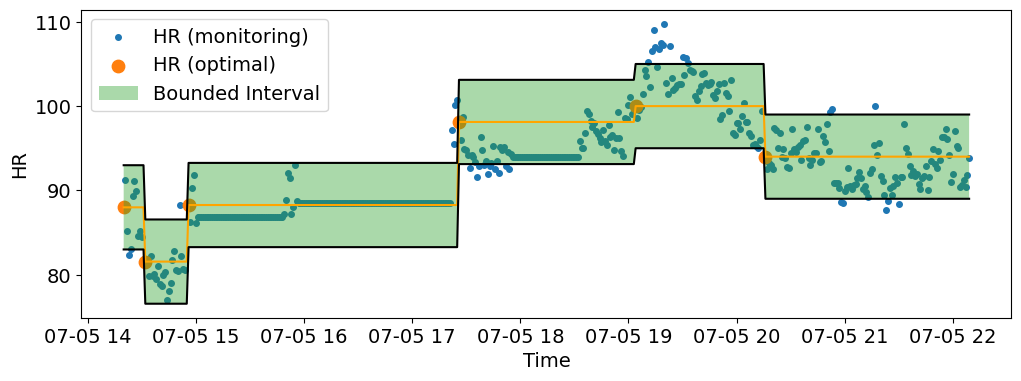

======= COL RR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (RR) = 0.9148936170212766 (430 / 470)


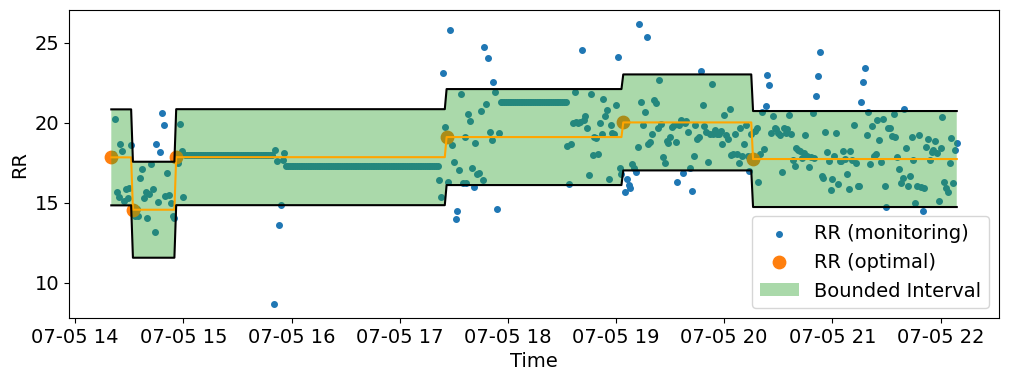

======= COL SpO2 ========
> waveform_times = min 2021-07-05 14:18:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (SpO2) = 0.9830508474576272 (464 / 472)


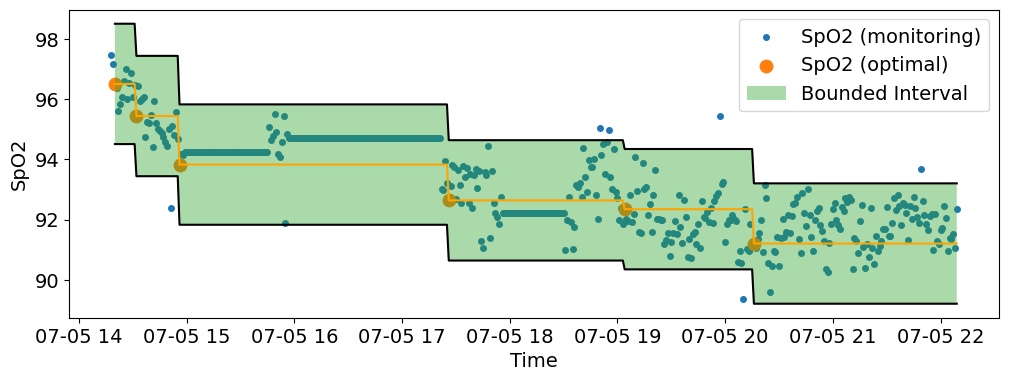

======= COL MAP ========
> waveform_times = min 2021-07-05 14:19:00-07:00; max 2021-07-05 15:00:00-07:00
> Coverage (MAP) = 0.9523809523809523 (40 / 42)


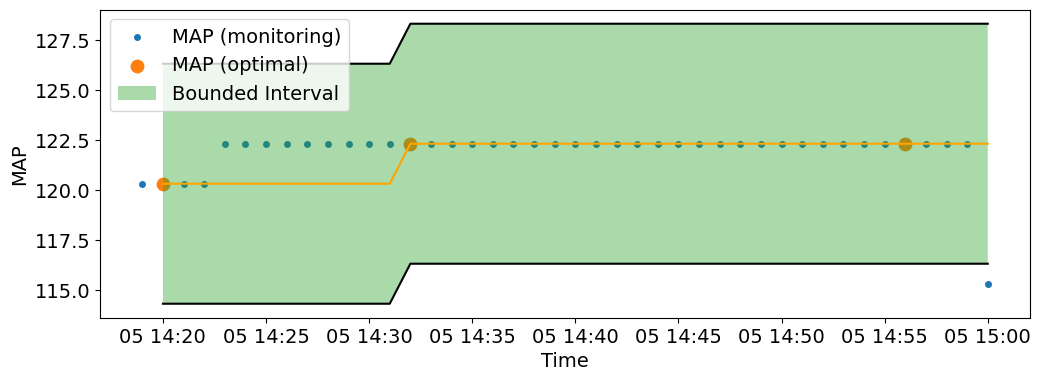

In [12]:
coverage_plots(df, 131311730708)

Working on 0/1 for CSN=131311730708...
> best_nurse_times = len 6 min 2021-07-05 14:20:00-07:00; max 2021-07-05 20:16:00-07:00
COVERAGE = [131311730708, 6, 825, 1454, 0.5674002751031637, 6, 1364, 1454, 0.938101788170564, 430, 470, 430, 470, 464, 472, 40, 42]
======= COL HR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (HR) = 0.9148936170212766 (430 / 470)


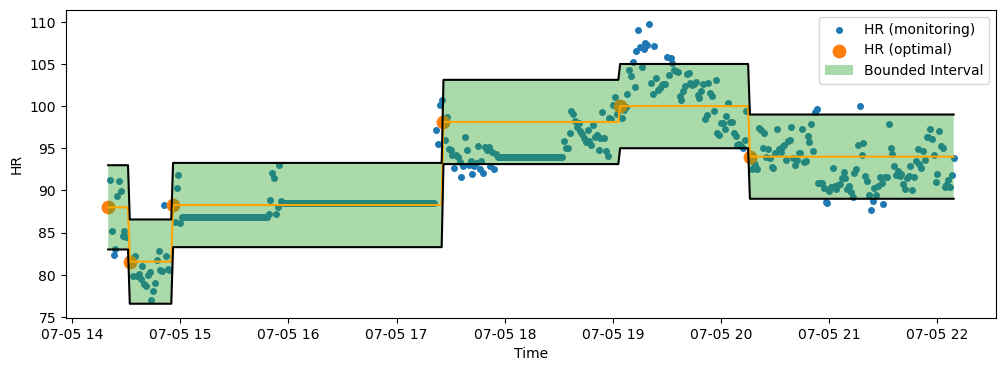

======= COL RR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (RR) = 0.9148936170212766 (430 / 470)


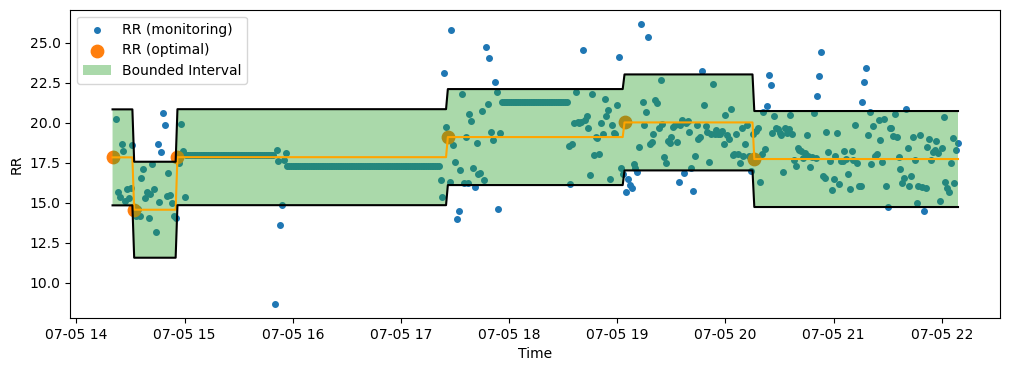

======= COL SpO2 ========
> waveform_times = min 2021-07-05 14:18:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (SpO2) = 0.9830508474576272 (464 / 472)


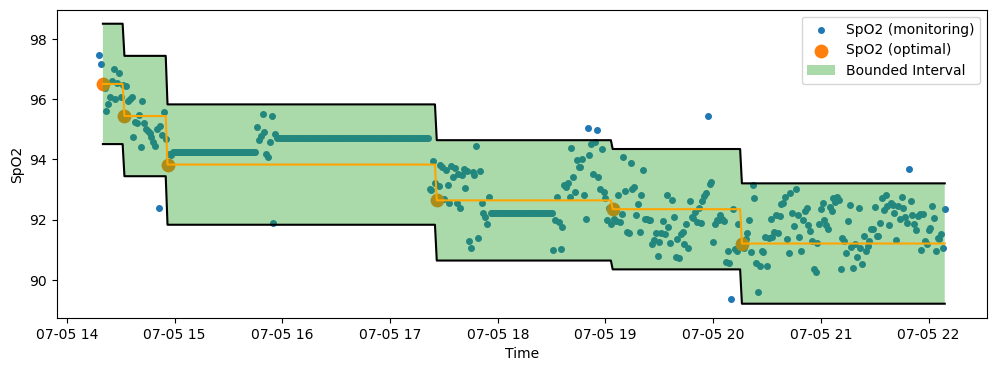

======= COL MAP ========
> waveform_times = min 2021-07-05 14:19:00-07:00; max 2021-07-05 15:00:00-07:00
> Coverage (MAP) = 0.9523809523809523 (40 / 42)


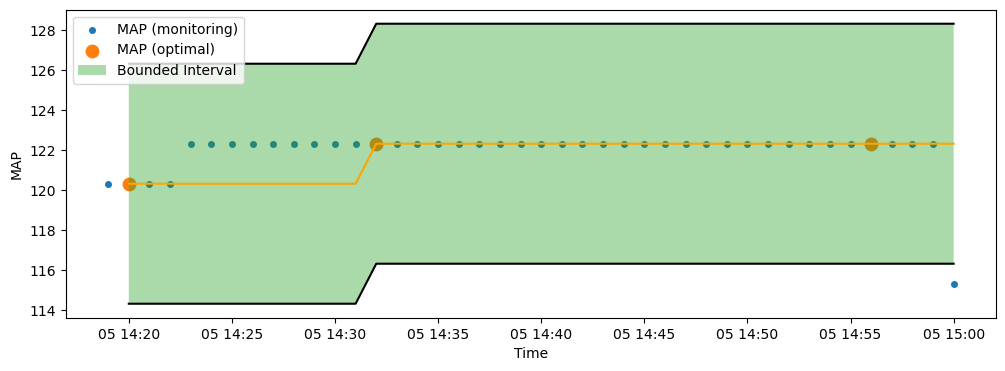

In [80]:
coverage_plots(df, 131311730708)

======= COL HR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (HR) = 0.725531914893617 (341 / 470)


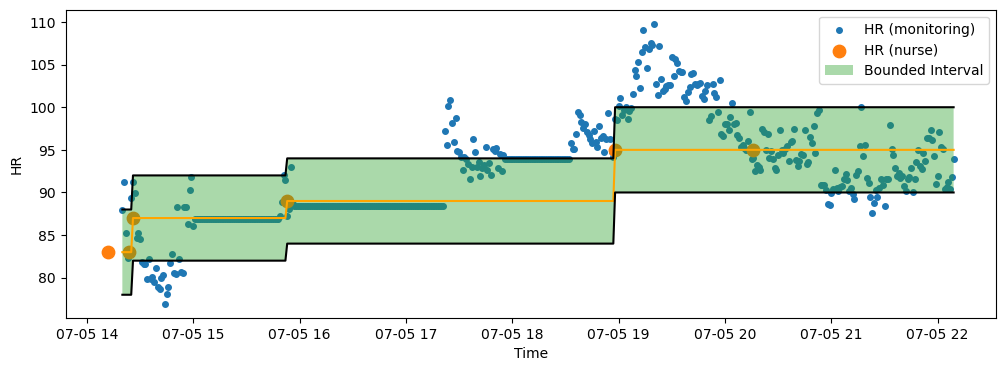

======= COL RR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (RR) = 0.32978723404255317 (155 / 470)


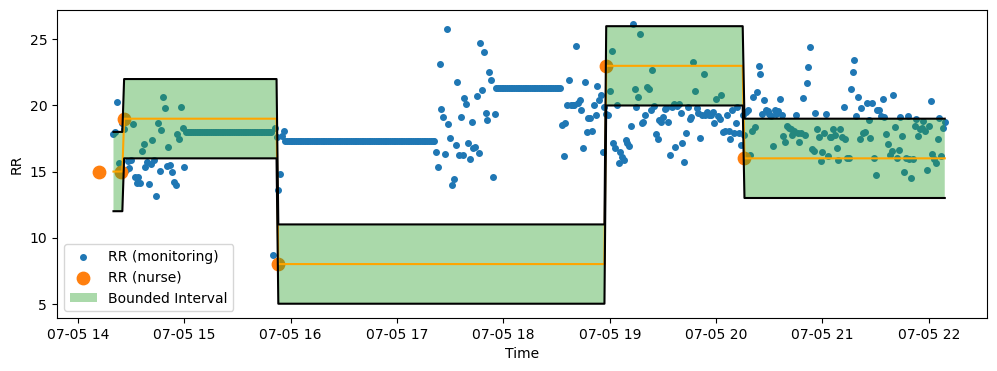

======= COL SpO2 ========
> waveform_times = min 2021-07-05 14:18:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (SpO2) = 0.6101694915254238 (288 / 472)


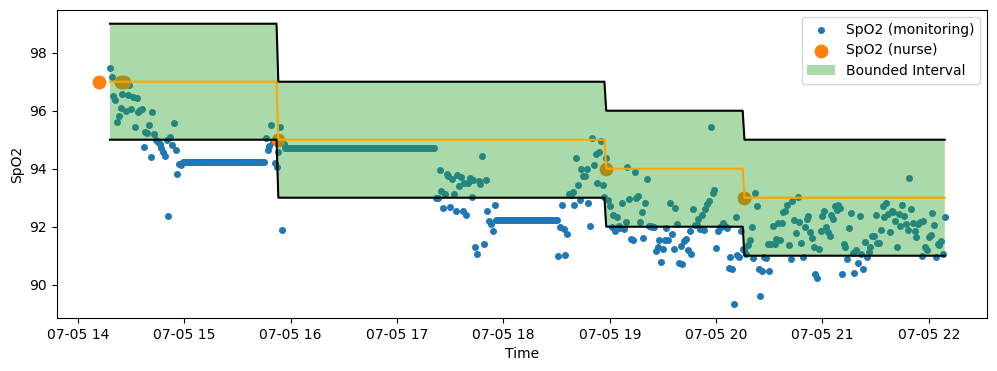

======= COL MAP ========
> waveform_times = min 2021-07-05 14:19:00-07:00; max 2021-07-05 15:00:00-07:00
> Coverage (MAP) = 0.9761904761904762 (41 / 42)


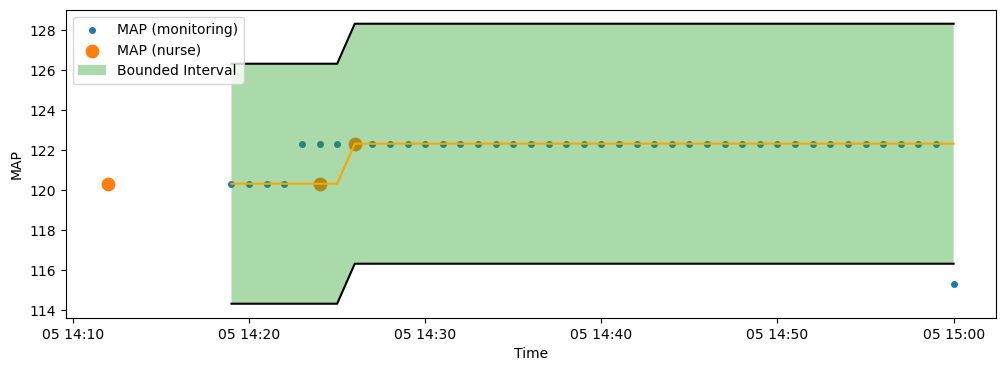

In [25]:
coverage_plots(df, 131311730708, True)

======= COL HR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (HR) = 0.725531914893617 (341 / 470)


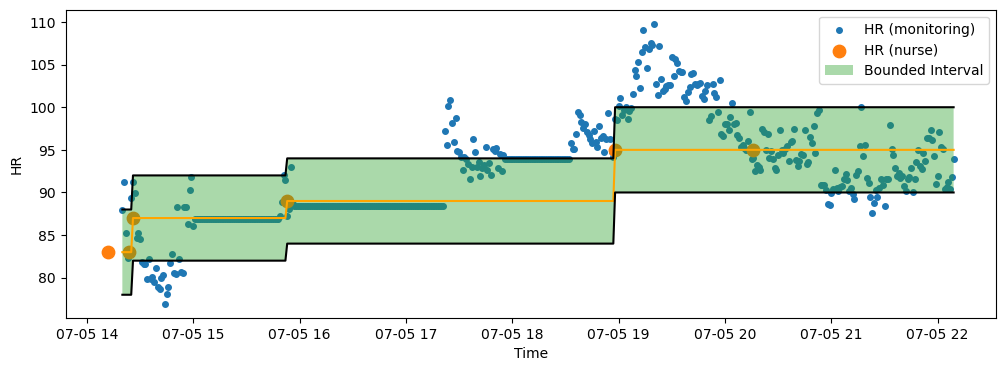

======= COL RR ========
> waveform_times = min 2021-07-05 14:20:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (RR) = 0.32978723404255317 (155 / 470)


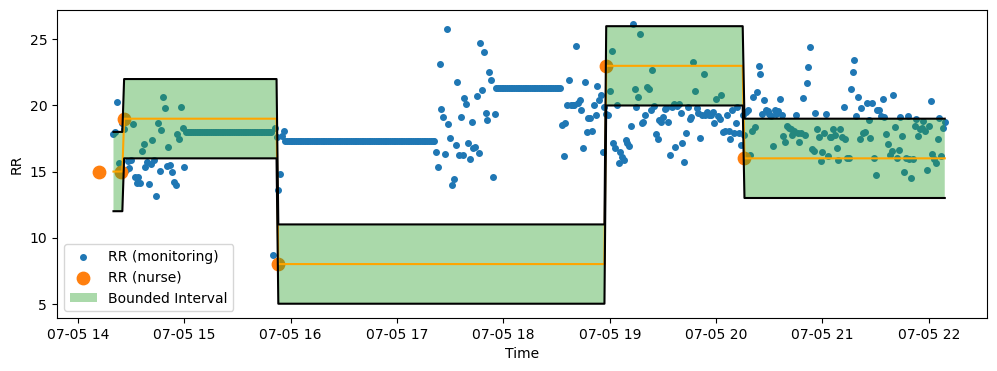

======= COL SpO2 ========
> waveform_times = min 2021-07-05 14:18:00-07:00; max 2021-07-05 22:09:00-07:00
> Coverage (SpO2) = 0.6101694915254238 (288 / 472)


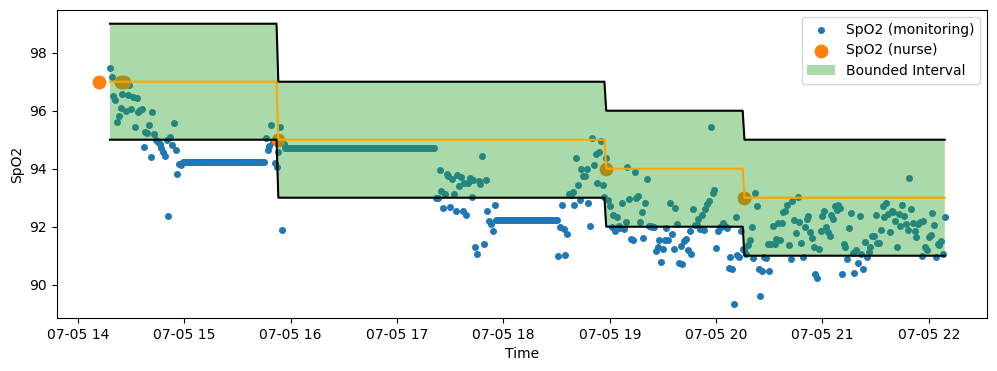

======= COL MAP ========
> waveform_times = min 2021-07-05 14:19:00-07:00; max 2021-07-05 15:00:00-07:00
> Coverage (MAP) = 0.9761904761904762 (41 / 42)


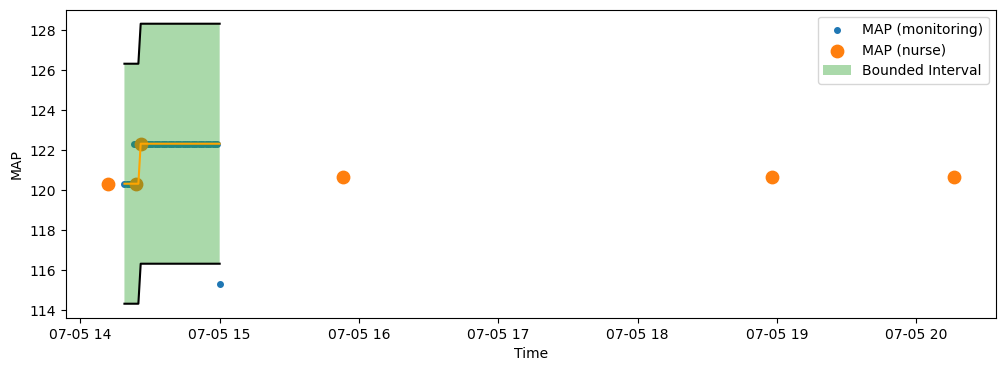

In [79]:
coverage_plots(df, 131311730708, True)

## CSN 131321054587

Working on 0/1 for CSN=131321054587...
> best_nurse_times = len 7 min 2021-12-05 12:15:00-08:00; max 2021-12-05 13:40:00-08:00
COVERAGE = [131321054587, 7, 274, 436, 0.6284403669724771, 7, 360, 436, 0.8256880733944955, 80, 109, 73, 108, 110, 113, 97, 106]
======= COL HR ========
> waveform_times = min 2021-12-05 12:19:00-08:00; max 2021-12-05 14:07:00-08:00
> Coverage (HR) = 0.7339449541284404 (80 / 109)


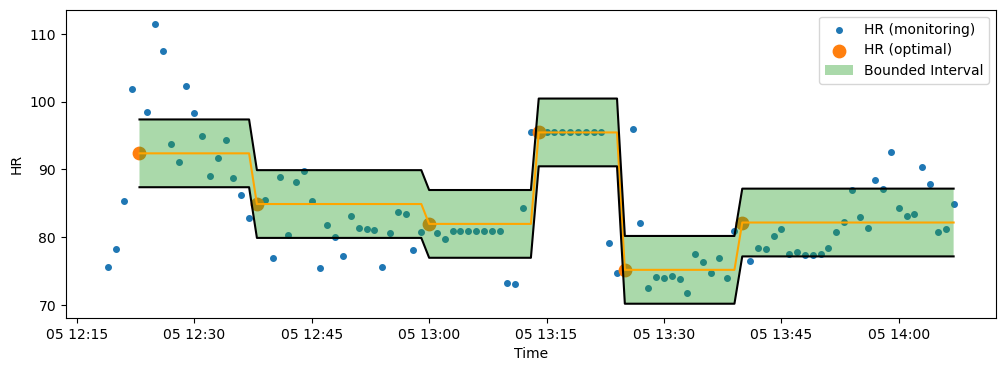

======= COL RR ========
> waveform_times = min 2021-12-05 12:20:00-08:00; max 2021-12-05 14:07:00-08:00
> Coverage (RR) = 0.6759259259259259 (73 / 108)


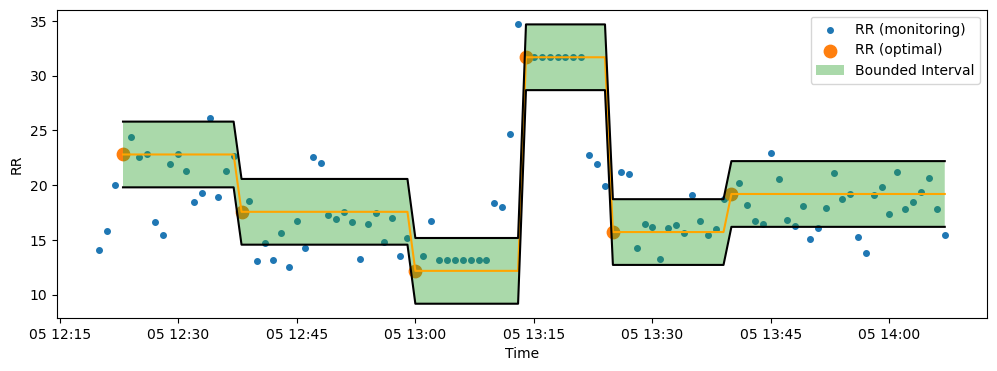

======= COL SpO2 ========
> waveform_times = min 2021-12-05 12:15:00-08:00; max 2021-12-05 14:07:00-08:00
> Coverage (SpO2) = 0.9734513274336283 (110 / 113)


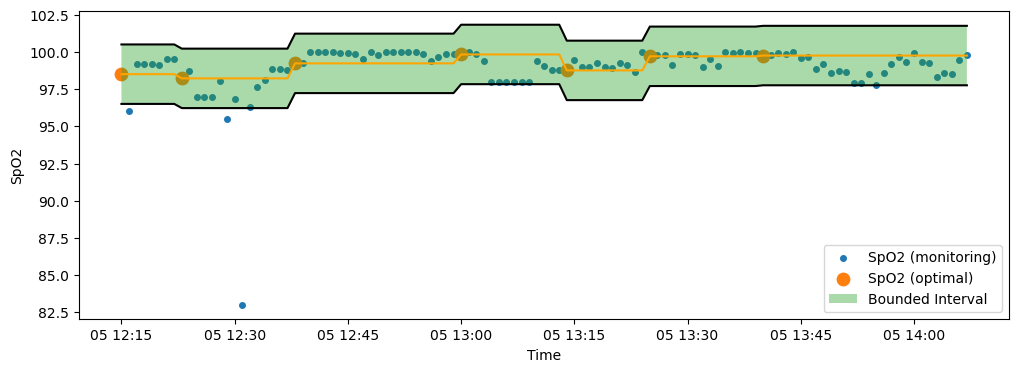

======= COL MAP ========
> waveform_times = min 2021-12-05 12:15:00-08:00; max 2021-12-05 14:00:00-08:00
> Coverage (MAP) = 0.9150943396226415 (97 / 106)


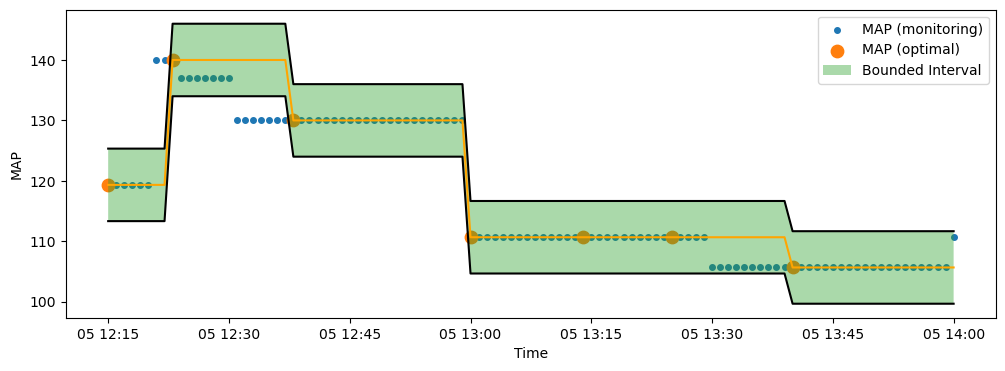

In [21]:
coverage_plots(df, 131321054587)

======= COL HR ========
> waveform_times = min 2021-12-05 12:19:00-08:00; max 2021-12-05 14:07:00-08:00
> Coverage (HR) = 0.3669724770642202 (40 / 109)


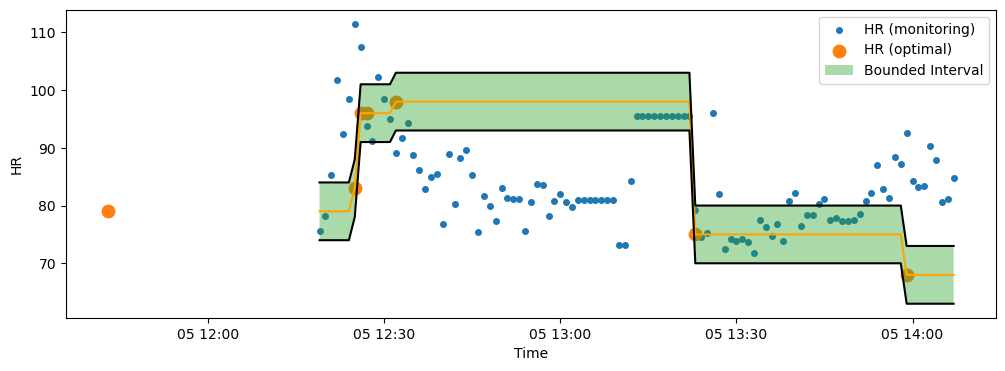

======= COL RR ========
> waveform_times = min 2021-12-05 12:20:00-08:00; max 2021-12-05 14:07:00-08:00
> Coverage (RR) = 0.5277777777777778 (57 / 108)


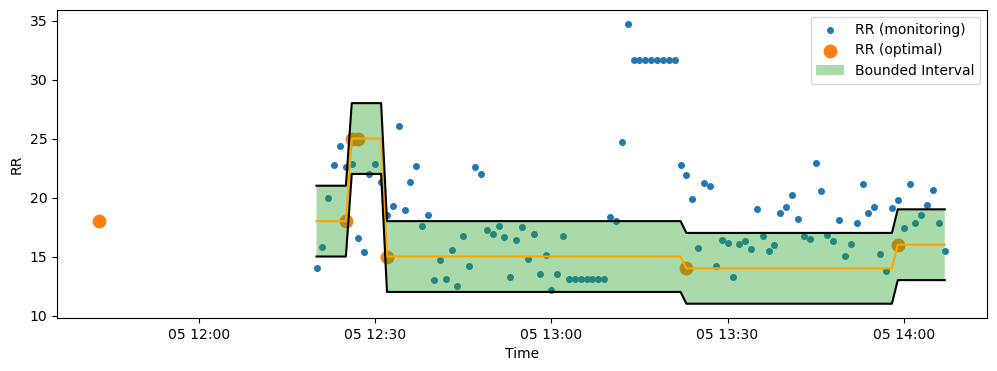

======= COL SpO2 ========
> waveform_times = min 2021-12-05 12:15:00-08:00; max 2021-12-05 14:07:00-08:00
> Coverage (SpO2) = 0.9469026548672567 (107 / 113)


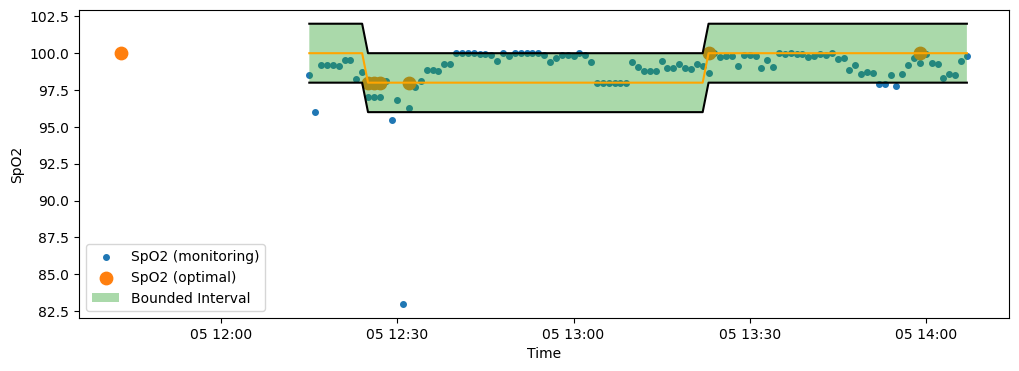

======= COL MAP ========
> waveform_times = min 2021-12-05 12:15:00-08:00; max 2021-12-05 14:00:00-08:00
> Coverage (MAP) = 0.660377358490566 (70 / 106)


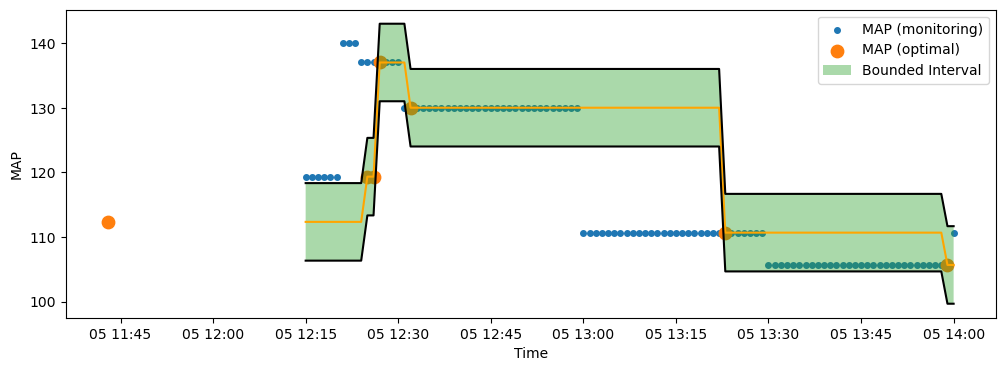

In [74]:
coverage_plots(df, 131321054587, True)